# Supervised simple classifier test

This notebook is testing the "simple classifier" model on the prelabeled Rainfall data for OCaml. The model has two parts: a recurrent neural network that encodes the token sequence into a fixed-size latent representation, and a linear (fully-connected) layer that classifies the latents into a label.

First, we set up the imports and dataset.

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import sys
sys.path.append('..')

In [57]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType
from scripts.rainfall_ingest import ingest_dataset

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os

device = torch.device('cpu')
REPO_DIR = os.path.expanduser('~/Code/autoplan')

In [58]:
# T1 refers to the OCaml data
dataset_name = 'T1'
dataset = ingest_dataset(dataset_name)

## Dataset

Each student program has a corresponding token sequence and provided label. The programs are preprocessed to remove any top-level syntax element that isn't a function definition, e.g. test cases and imports. An example is shown below:

In [59]:
print('Total number of programs: {}'.format(len(dataset.dataset)))
print('One example dataset entry:\n')
item = dataset.dataset[5]
print('SOURCE:')
print(item['source'])
print('TOKENS:')
print(item['program'])
print('LABEL')
print(item['labels'].item())

Total number of programs: 45
One example dataset entry:

SOURCE:
let rec rainfall (alon : int list) =
  (let rec avg_rain (alon : int list) (sum : int) (count : int) =
     (match alon with
      | [] -> if count = 0 then 0 else sum / count
      | hd::tl ->
          if hd > 0
          then avg_rain tl (sum + hd) (count + 1)
          else
            if hd > (-999)
            then avg_rain tl sum count
            else avg_rain [] sum count : int) in
   avg_rain alon 0 0 : int)

TOKENS:
tensor([ 0,  1,  2,  3,  2,  4,  2,  2,  5,  6,  3,  0,  1,  2,  3,  2,  4,  2,
         2,  5,  3,  2,  4,  2,  5,  3,  2,  4,  2,  5,  6,  3,  7,  2,  9, 10,
        11, 12, 14, 20,  2,  6, 29, 22, 29, 25,  2, 30,  2, 10,  2, 18,  2, 14,
        20,  2, 32, 29, 22,  2,  2,  3,  2, 34,  2,  5,  3,  2, 34, 33,  5, 25,
        20,  2, 32,  3, 16, 31,  5, 22,  2,  2,  2,  2, 25,  2, 11, 12,  2,  2,
         4,  2,  5, 27,  2,  2, 29, 29,  4,  2,  5])
LABEL
2


## Training

The student data is randomly split into a training and validation set, 50% to each, and the model goes through a standard supervised gradient descent training loop. This is using a mildly-educated default guess for the various hyperparameters (learning rate, model size, etc.).

In [75]:
trainer = ClassifierTrainer(dataset, device=device, val_frac=0.5)
losses, train_eval, val_eval = trainer.train(epochs=100)

100%|██████████| 100/100 [01:17<00:00,  1.49it/s]


## Evaluation

The loss goes down smoothly and bottoms out, suggesting the network has learned as much as it can.

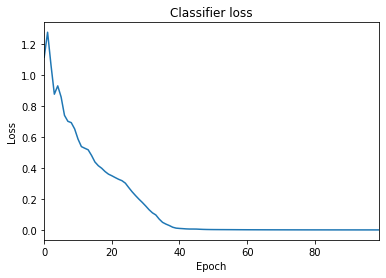

In [76]:
plot_loss(losses, title='Classifier loss')

The training set accuracy reaches 100%, confirming the previous hypothesis: the network has memorized the training set.

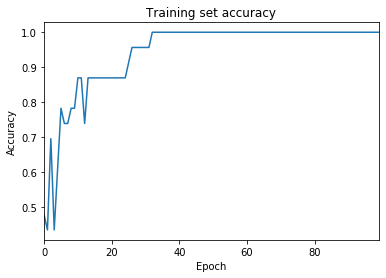

In [77]:
plot_accuracy(train_eval, title='Training set accuracy')

The validation set accuracy is surprisingly good before the network overfits, reaching about 80%.

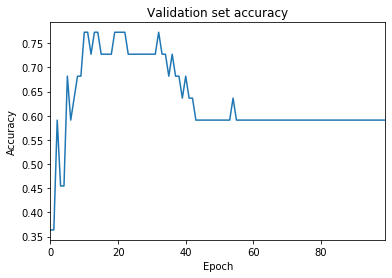

In [78]:
plot_accuracy(val_eval, title='Validation set accuracy')

Digging in, we show the (unnormalized) confusion matrix for the validation set at the epoch of highest overall validation accuracy. CleanFirst is mis-predicted more than the other classes.

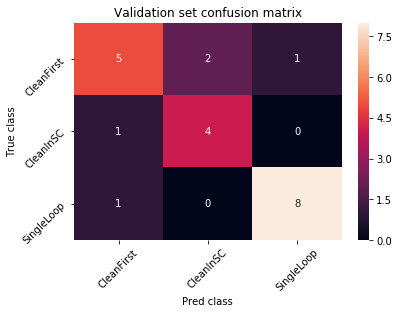

In [79]:
i = np.argmax([eval_.accuracy for eval_ in val_eval])
val_eval[i].plot_cm('Validation set confusion matrix', normalize=False)

## Conclusion

This experiment suggests that the simple classifier approach shows promise. The next step is to do a more careful parameter sweep and ablation study to understand how each hyperparameter and design choice (e.g. tokenization strategy) impacts the final performance.